In [1]:
from collections import defaultdict
import os
import torch
import random
import numpy as np
import pandas as pd
import json
import pickle
import gzip
from tqdm import tqdm

def load_pickle(filename):
    with open(filename, "rb") as f:
        return pickle.load(f)


def save_pickle(data, filename):
    with open(filename, "wb") as f:
        pickle.dump(data, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)
    
def ReadLineFromFile(path):
    lines = []
    with open(path,'r') as fd:
        for line in fd:
            lines.append(line.rstrip('\n'))
    return lines

def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)
        
'''
Set seeds
'''
seed = 2022
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

In [2]:
short_data_name = 'yelp'
full_data_name = 'Yelp'
os.mkdir(short_data_name)

### For Sequential Recommendation

In [3]:
def Yelp(date_min, date_max, rating_score):
    datas = []
    data_flie = './raw_data/yelp/yelp_academic_dataset_review.json'
    lines = open(data_flie).readlines()
    for line in tqdm(lines):
        review = json.loads(line.strip())
        user = review['user_id']
        item = review['business_id']
        rating = review['stars']
        # 2004-10-12 10:13:32 2019-12-13 15:51:19
        date = review['date']
        # 剔除一些例子
        if date < date_min or date > date_max or float(rating) <= rating_score:
            continue
        time = date.replace('-','').replace(':','').replace(' ','')
        datas.append((user, item, int(time)))
    return datas

def Yelp_meta(datamaps):
    meta_infos = {}
    meta_file = './raw_data/yelp/yelp_academic_dataset_business.json'
    item_ids = list(datamaps['item2id'].keys())
    lines = open(meta_file).readlines()
    for line in tqdm(lines):
        info = json.loads(line)
        if info['business_id'] not in item_ids:
            continue
        meta_infos[info['business_id']] = info
    return meta_infos


def add_comma(num):
    # 1000000 -> 1,000,000
    str_num = str(num)
    res_num = ''
    for i in range(len(str_num)):
        res_num += str_num[i]
        if (len(str_num)-i-1) % 3 == 0:
            res_num += ','
    return res_num[:-1]

def get_attribute_Yelp(meta_infos, datamaps, attribute_core):
    attributes = defaultdict(int)
    for iid, info in tqdm(meta_infos.items()):
        try:
            cates = [cate.strip() for cate in info['categories'].split(',')]
            for cate in cates:
                attributes[cate] +=1
        except:
            pass
    print(f'before delete, attribute num:{len(attributes)}')
    new_meta = {}
    for iid, info in tqdm(meta_infos.items()):
        new_meta[iid] = []
        try:
            cates = [cate.strip() for cate in info['categories'].split(',') ]
            for cate in cates:
                if attributes[cate] >= attribute_core:
                    new_meta[iid].append(cate)
        except:
            pass
    # 做映射
    attribute2id = {}
    id2attribute = {}
    attribute_id = 1
    items2attributes = {}
    attribute_lens = []
    # load id map
    for iid, attributes in new_meta.items():
        item_id = datamaps['item2id'][iid]
        items2attributes[item_id] = []
        for attribute in attributes:
            if attribute not in attribute2id:
                attribute2id[attribute] = attribute_id
                id2attribute[attribute_id] = attribute
                attribute_id += 1
            items2attributes[item_id].append(attribute2id[attribute])
        attribute_lens.append(len(items2attributes[item_id]))
    print(f'after delete, attribute num:{len(attribute2id)}')
    print(f'attributes len, Min:{np.min(attribute_lens)}, Max:{np.max(attribute_lens)}, Avg.:{np.mean(attribute_lens):.4f}')
    # 更新datamap
    datamaps['attribute2id'] = attribute2id
    datamaps['id2attribute'] = id2attribute
    return len(attribute2id), np.mean(attribute_lens), datamaps, items2attributes


def get_interaction(datas):
    user_seq = {}
    for data in datas:
        user, item, time = data
        if user in user_seq:
            user_seq[user].append((item, time))
        else:
            user_seq[user] = []
            user_seq[user].append((item, time))

    for user, item_time in user_seq.items():
        item_time.sort(key=lambda x: x[1])  # 对各个数据集得单独排序
        items = []
        for t in item_time:
            items.append(t[0])
        user_seq[user] = items
    return user_seq

# K-core user_core item_core
def check_Kcore(user_items, user_core, item_core):
    user_count = defaultdict(int)
    item_count = defaultdict(int)
    for user, items in user_items.items():
        for item in items:
            user_count[user] += 1
            item_count[item] += 1

    for user, num in user_count.items():
        if num < user_core:
            return user_count, item_count, False
    for item, num in item_count.items():
        if num < item_core:
            return user_count, item_count, False
    return user_count, item_count, True # 已经保证Kcore

# 循环过滤 K-core
def filter_Kcore(user_items, user_core, item_core): # user 接所有items
    user_count, item_count, isKcore = check_Kcore(user_items, user_core, item_core)
    while not isKcore:
        for user, num in user_count.items():
            if user_count[user] < user_core: # 直接把user 删除
                user_items.pop(user)
            else:
                for item in user_items[user]:
                    if item_count[item] < item_core:
                        user_items[user].remove(item)
        user_count, item_count, isKcore = check_Kcore(user_items, user_core, item_core)
    return user_items

def id_map(user_items): # user_items dict
    user2id = {} # raw 2 uid
    item2id = {} # raw 2 iid
    id2user = {} # uid 2 raw
    id2item = {} # iid 2 raw
    user_id = 1
    item_id = 1
    final_data = {}
    for user, items in user_items.items():
        if user not in user2id:
            user2id[user] = str(user_id)
            id2user[str(user_id)] = user
            user_id += 1
        iids = [] # item id lists
        for item in items:
            if item not in item2id:
                item2id[item] = str(item_id)
                id2item[str(item_id)] = item
                item_id += 1
            iids.append(item2id[item])
        uid = user2id[user]
        final_data[uid] = iids
    data_maps = {
        'user2id': user2id,
        'item2id': item2id,
        'id2user': id2user,
        'id2item': id2item
    }
    return final_data, user_id-1, item_id-1, data_maps

In [4]:
def main(data_name, acronym, data_type='Amazon'):
    assert data_type in {'Amazon', 'Yelp'}
    rating_score = 0.0  # rating score smaller than this score would be deleted
    # user 5-core item 5-core
    user_core = 5
    item_core = 5
    attribute_core = 0

    if data_type == 'Yelp':
        date_max = '2019-12-31 00:00:00'
        date_min = '2019-01-01 00:00:00'
        datas = Yelp(date_min, date_max, rating_score)
        #uis_triplets = load_pickle('yelp/pre_uis_triplets.pkl')
        #datas = Yelp(uis_triplets, rating_score)
    else:
        datas = Amazon(data_name+'_5', rating_score=rating_score)

    user_items = get_interaction(datas)
    print(f'{data_name} Raw data has been processed! Lower than {rating_score} are deleted!')
    # raw_id user: [item1, item2, item3...]
    user_items = filter_Kcore(user_items, user_core=user_core, item_core=item_core)
    print(f'User {user_core}-core complete! Item {item_core}-core complete!')

    user_items, user_num, item_num, data_maps = id_map(user_items)  # new_num_id
    user_count, item_count, _ = check_Kcore(user_items, user_core=user_core, item_core=item_core)
    user_count_list = list(user_count.values())
    user_avg, user_min, user_max = np.mean(user_count_list), np.min(user_count_list), np.max(user_count_list)
    item_count_list = list(item_count.values())
    item_avg, item_min, item_max = np.mean(item_count_list), np.min(item_count_list), np.max(item_count_list)
    interact_num = np.sum([x for x in user_count_list])
    sparsity = (1 - interact_num / (user_num * item_num)) * 100
    show_info = f'Total User: {user_num}, Avg User: {user_avg:.4f}, Min Len: {user_min}, Max Len: {user_max}\n' + \
                f'Total Item: {item_num}, Avg Item: {item_avg:.4f}, Min Inter: {item_min}, Max Inter: {item_max}\n' + \
                f'Iteraction Num: {interact_num}, Sparsity: {sparsity:.2f}%'
    print(show_info)


    print('Begin extracting meta infos...')

    if data_type == 'Amazon':
        meta_infos = Amazon_meta(data_name, data_maps)
        attribute_num, avg_attribute, datamaps, item2attributes = get_attribute_Amazon(meta_infos, data_maps, attribute_core)
    else:
        meta_infos = Yelp_meta(data_maps)
        attribute_num, avg_attribute, datamaps, item2attributes = get_attribute_Yelp(meta_infos, data_maps, attribute_core)

    print(f'{data_name} & {add_comma(user_num)}& {add_comma(item_num)} & {user_avg:.1f}'
          f'& {item_avg:.1f}& {add_comma(interact_num)}& {sparsity:.2f}\%&{add_comma(attribute_num)}&'
          f'{avg_attribute:.1f} \\')

    # -------------- Save Data ---------------
    data_file = './{}/'.format(acronym) + 'sequential_data.txt'
    item2attributes_file = './{}/'.format(acronym) + 'item2attributes.json'
    datamaps_file = './{}/'.format(acronym) + 'datamaps.json'

    with open(data_file, 'w') as out:
        for user, items in user_items.items():
            out.write(user + ' ' + ' '.join(items) + '\n')
    json_str = json.dumps(item2attributes)
    with open(item2attributes_file, 'w') as out:
        out.write(json_str)
        
    json_str = json.dumps(datamaps)
    with open(datamaps_file, 'w') as out:
        out.write(json_str)

In [5]:
main(full_data_name, short_data_name, data_type='Yelp')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8021122/8021122 [00:40<00:00, 197260.88it/s]


Yelp Raw data has been processed! Lower than 0.0 are deleted!
User 5-core complete! Item 5-core complete!
Total User: 30431, Avg User: 10.3958, Min Len: 5, Max Len: 350
Total Item: 20033, Avg Item: 15.7916, Min Inter: 5, Max Inter: 500
Iteraction Num: 316354, Sparsity: 99.95%
Begin extracting meta infos...


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20033/20033 [00:00<00:00, 518269.80it/s]


before delete, attribute num:1001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20033/20033 [00:00<00:00, 429671.92it/s]


after delete, attribute num:1001
attributes len, Min:0, Max:20, Avg.:4.8430
Yelp & 30,431& 20,033 & 10.4& 15.8& 316,354& 99.95\%&1,001&4.8 \


In [6]:
def sample_test_data(data_name, test_num=99, sample_type='random'):
    """
    sample_type:
        random:  sample `test_num` negative items randomly.
        pop: sample `test_num` negative items according to item popularity.
    """

    data_file = f'sequential_data.txt'
    test_file = f'negative_samples.txt'

    item_count = defaultdict(int)
    user_items = defaultdict()

    lines = open('./{}/'.format(data_name) + data_file).readlines()
    for line in lines:
        user, items = line.strip().split(' ', 1)
        items = items.split(' ')
        items = [int(item) for item in items]
        user_items[user] = items
        for item in items:
            item_count[item] += 1

    all_item = list(item_count.keys())
    count = list(item_count.values())
    sum_value = np.sum([x for x in count])
    probability = [value / sum_value for value in count]

    user_neg_items = defaultdict()

    for user, user_seq in user_items.items():
        test_samples = []
        while len(test_samples) < test_num:
            if sample_type == 'random':
                sample_ids = np.random.choice(all_item, test_num, replace=False)
            else: # sample_type == 'pop':
                sample_ids = np.random.choice(all_item, test_num, replace=False, p=probability)
            sample_ids = [str(item) for item in sample_ids if item not in user_seq and item not in test_samples]
            test_samples.extend(sample_ids)
        test_samples = test_samples[:test_num]
        user_neg_items[user] = test_samples

    with open('./{}/'.format(data_name) + test_file, 'w') as out:
        for user, samples in user_neg_items.items():
            out.write(user+' '+' '.join(samples)+'\n')

In [7]:
sample_test_data(short_data_name)

### Create Splits for Review

In [8]:
datamaps = load_json("./{}/datamaps.json".format(short_data_name))
print(datamaps.keys())

dict_keys(['user2id', 'item2id', 'id2user', 'id2item', 'attribute2id', 'id2attribute'])


In [9]:
date_max = '2019-12-31 00:00:00'
date_min = '2019-01-01 00:00:00'
rating_score = 0.0
all_review_data = []
lines = open('./raw_data/yelp/yelp_academic_dataset_review.json').readlines()
for line in tqdm(lines):
    review = json.loads(line.strip())
    # all: 2004-10-12 10:13:32 2019-12-13 15:51:19
    # desired: 2019-01-01 00:00:00 2019-12-31 00:00:00
    date = review['date']
    rating = review['stars']
    if date < date_min or date > date_max or float(rating) <= rating_score:
        continue
    user = review['user_id']
    item = review['business_id']
    if user in datamaps['user2id'] and item in datamaps['item2id']:
        pass
    else:
        continue
    time = date.replace('-','').replace(':','').replace(' ','')
    review['unixReviewTime'] = time
    review['reviewerID'] = user
    review['asin'] = item
    review['overall'] = rating
    review['reviewText'] = review['text']
    del review['text']
    del review['user_id']
    del review['business_id']
    del review['stars']
    all_review_data.append(review)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8021122/8021122 [00:41<00:00, 194307.65it/s]


In [10]:
print(len(all_review_data))
print(all_review_data[0])

316354
{'review_id': 'Vx-DPb4olxt1Zxf9dI8b2A', 'useful': 0, 'funny': 0, 'cool': 0, 'date': '2019-01-02 19:11:49', 'unixReviewTime': '20190102191149', 'reviewerID': 'Donht4mLJ4aO4FQhqHGJtw', 'asin': '5eV8oUGdBXylwB7HeaDFOA', 'overall': 4.0, 'reviewText': 'Top notch cuisine and very friendly service. Everything here tastes very fresh. The rice pilaf is second to none!! Prices are very reasonable for the high quality food they serve!!'}


In [11]:
def save_json_gz(jsonfilename, data):
    with gzip.open(jsonfilename, 'w') as fout:
        fout.write(json.dumps(data).encode('utf-8'))
        
def load_json_gz(jsonfilename):
    with gzip.open(jsonfilename, 'r') as fin:
        data = json.loads(fin.read().decode('utf-8'))
    return data

In [12]:
review_data = load_json_gz('./raw_data/reviews_Yelp_5.json.gz')
print(len(review_data))
review_data[0]

316354


{'review_id': 'Vx-DPb4olxt1Zxf9dI8b2A',
 'useful': 0,
 'funny': 0,
 'cool': 0,
 'date': '2019-01-02 19:11:49',
 'unixReviewTime': '20190102191149',
 'reviewerID': 'Donht4mLJ4aO4FQhqHGJtw',
 'asin': '5eV8oUGdBXylwB7HeaDFOA',
 'overall': 4.0,
 'reviewText': 'Top notch cuisine and very friendly service. Everything here tastes very fresh. The rice pilaf is second to none!! Prices are very reasonable for the high quality food they serve!!'}

In [13]:
print(len(datamaps['user2id']))
print(len(datamaps['item2id']))
sparsity = 100.0 * len(review_data) / (len(datamaps['user2id']) * len(datamaps['item2id'])) 
print('sparsity: ', sparsity)

30431
20033
sparsity:  0.05189327918159184


In [14]:
valid_review_indices = []
for i in tqdm(range(len(review_data))):
    if review_data[i]['reviewerID'] in datamaps['user2id'] and review_data[i]['asin'] in datamaps['item2id']:
        valid_review_indices.append(i)
print(len(valid_review_indices))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316354/316354 [00:00<00:00, 1623301.29it/s]

316354


### Prepare reviews.pickle

In [15]:
raw_explanations = load_pickle('./raw_data/reviews_{}.pickle'.format(full_data_name))
print(len(raw_explanations))
print(raw_explanations[2])

316354
{'user': 'Tc0DsCR2k5XZAqqjRDtDfg', 'item': '5eV8oUGdBXylwB7HeaDFOA', 'rating': 5, 'text': 'If I could give 6 stars I would. My wife and I dine here several times a month and are never disappointed. Everything is always fresh and well prepared. If we have any complaints at all it would be for them to add humus and tabouli. Would also like to comment on the great service. Thanks guys.', 'sentence': [('service', 'great', 'Would also like to comment on the great service', 1), ('service', 'great', 'great service', 1), ('service', 'great', 'great service', 1)]}


In [16]:
raw_explanations[1]

{'user': 'pGvCyc6xVOyoxeIDgafCCQ',
 'item': '5eV8oUGdBXylwB7HeaDFOA',
 'rating': 4,
 'text': 'I tried the steak entree plate that came with a side salad, pita bread, 2 skewers of steak, and their yogurt sauce (forgot the name). \n\nI think my first mistake was that I order the steak "well done" as I hate raw steak but I hadn\'t realized that it was sirloin steak. The steak was chewy and honestly I almost choked on it. The side salad and it\'s dressing was really good except I bit into an olive not knowing there was a seed in it! Good thing I didn\'t break my tooth! \n\nThe food was just okay. \n\nOn the other hand, I order a piece of baklava and oohhh my goodness gracious, I\'m not even a sweets lover, but dayum this dessert was top notch! The top was flaky and as you got to the bottom of the piece it would get more and more sweet. But not too sweet as I believe it\'s sweetened with honey. It was like. So. Good. I was supposed to share half with my boyfriend but I ate the whole thing! 

In [17]:
all_review_data[1]

{'review_id': 'eyUE1Lte1Loac-y9kpqbCQ',
 'useful': 2,
 'funny': 0,
 'cool': 2,
 'date': '2019-01-14 18:47:55',
 'unixReviewTime': '20190114184755',
 'reviewerID': 'kUUls6-NU6eSYeTXHtSPbA',
 'asin': '1WtUgLhdBdQ39aBvEUbsnw',
 'overall': 4.0,
 'reviewText': "The fact that all of their sushi is buy one, get one free all of the time here is amazing! I was so tempted to order more food, but my two sushi rolls and the delicious appetizers that my friends ordered for the table were plenty enough! One friend ordered the shrimp shumai and pork gyoza (both steamed, of course) and another friend ordered the spicy edamame... all of which was delicious! \n\nThe service we received was excellent and the sushi and sake were great as well. My one friend did not like one of her rolls though and I cant blame her because it was very odd. She ended up getting a crunchy roll which was literally just that. It was filled with crunchy topping and nothing else, then topped with spicy mayo and eel sauce (I thin

In [18]:
rev_uis_triplets = {}
all_user_ids = []
all_item_ids = []
all_review_ids = []

for ind in range(len(all_review_data)):
    rev_ = all_review_data[ind]
    u_ = rev_['reviewerID']
    i_ = rev_['asin']
    r_ = rev_['review_id']
    s_ = int(rev_['overall'])
    all_user_ids.append(u_)
    all_item_ids.append(i_)
    all_review_ids.append(r_)
    if (u_, i_, s_) not in rev_uis_triplets:
        rev_uis_triplets[(u_, i_, s_)] = [ind]
    else:
        rev_uis_triplets[(u_, i_, s_)].append(ind)

In [19]:
all_user_ids = set(all_user_ids)
all_item_ids = set(all_item_ids)
all_review_ids = set(all_review_ids)

In [20]:
print(len(all_review_ids))

316354


In [21]:
len(raw_explanations)

316354

In [22]:
for j in range(len(raw_explanations)):
    key = (raw_explanations[j]['user'], raw_explanations[j]['item'], int(raw_explanations[j]['rating']))
    if key not in rev_uis_triplets:
        break

In [23]:
j

316353

In [24]:
key

('dcaM83FOnpuqxGJt4EABZA', 'dHgbL5EAEawIcqk6aXe2Ow', 1)

In [25]:
raw_explanations[j]

{'user': 'dcaM83FOnpuqxGJt4EABZA',
 'item': 'dHgbL5EAEawIcqk6aXe2Ow',
 'rating': 1,
 'text': 'When I walked in there was no one to greet me despite them not being very busy. I went and sat at the bar a just hoped that someone would take my order. I got the lobster ravioli the food was ok but not really worth the price. My bartender/ server was very nice and attentive but the manager?/hostess was so rude and so loud. She was cursing up a storm talking to one of the waiters andI thought it was just very unprofessional. When I was getting ready to leave I saw a group of elder black women leaving and the hostess was shouting at them and making a scened and being extremely rude. As I walked out and talked to them and they told me about the terrible experience they had. They said they came 5 min late to their reservation and the hostess immediately started yelling at them and tried to turn them away. Then when they finally got seated and ordered, it tool over an hour for them to get their me

In [26]:
sum([len(rev_uis_triplets[k]) for k in list(rev_uis_triplets.keys())])

316354

In [27]:
sum([1 for k in list(rev_uis_triplets.keys())])

308579

In [28]:
sum([1 for k in list(rev_uis_triplets.keys()) if len(rev_uis_triplets[k]) == 1])

301912

In [29]:
all_review_data = load_json_gz('./raw_data/reviews_Yelp_5.json.gz')

In [30]:
combined_review_data = []
no_sentence = 0
multiple_indices = []
for j in range(len(raw_explanations)):
    key = (raw_explanations[j]['user'], raw_explanations[j]['item'], int(raw_explanations[j]['rating']))
    if key in rev_uis_triplets:
        if len(rev_uis_triplets[key]) == 1:
            rev_ = all_review_data[rev_uis_triplets[key][0]]
            exp_ = raw_explanations[j]
            assert rev_['reviewerID'] == exp_['user']
            assert rev_['asin'] == exp_['item']
            if 'sentence' in exp_:
                list_len = len(exp_['sentence'])
                selected_idx = random.randint(0, list_len-1)
                rev_['explanation'] = exp_['sentence'][selected_idx][2]
                rev_['feature'] = exp_['sentence'][selected_idx][0]   # add a random, or list all possible sentences
            else:
                no_sentence += 1
            combined_review_data.append(rev_)
        else:
            multiple_indices.append(j)
            for k_ in rev_uis_triplets[key]:
                if all_review_data[k_]['reviewText'] == raw_explanations[j]['text']:
                    rev_ = all_review_data[k_]
                    exp_ = raw_explanations[j]
                    assert rev_['reviewerID'] == exp_['user']
                    assert rev_['asin'] == exp_['item']
                    if 'sentence' in exp_:
                        list_len = len(exp_['sentence'])
                        selected_idx = random.randint(0, list_len-1)
                        rev_['explanation'] = exp_['sentence'][selected_idx][2]
                        rev_['feature'] = exp_['sentence'][selected_idx][0]   # add a random, or list all possible sentences
                    else:
                        no_sentence += 1
                    combined_review_data.append(rev_)
                    break

In [31]:
len(combined_review_data)

316354

In [32]:
multiple_indices[20]

422

In [33]:
key = (raw_explanations[422]['user'], raw_explanations[422]['item'], int(raw_explanations[422]['rating']))

In [34]:
len(rev_uis_triplets[key])

2

In [35]:
rev_uis_triplets[key]

[19145, 27837]

In [36]:
raw_explanations[422]

{'user': 'J4LGq7xYlHDfbfHbwbyK8Q',
 'item': 'e3PBfbtXUjMziX6XGsOMoA',
 'rating': 4,
 'text': "We've tried really good udon, from Tokyo to those hidden gem noodle houses in LA & Torrance, CA and I have to say Cafe Sanuki's is on par. The ordering system is cafeteria style where you walk in, get a tray and pick your dishes or order them at the counter if it isn't there. I've been wanting to try their Carbonara Udon after seeing it on their Instagram page and I wasn't disappointed. The Carbonara sauce (not just a dressed up Alfredo) was authentic-tasting, right down to the generous sprinkling of hand-cut bacon chunks--yes, chunks, not those dried bacon bits found in shakers. My wife opted for the more traditional Niku Beef Udon which boasts Sanuki's silky soft udon noodles served in rich and flavorful signature broth topped with green onions, tender marinated beef! Cafe Sanuki's price is also on point, which is why we also tried a few side dishes like their Takoyaki and Pork Belly Bao. Th

In [37]:
all_review_data[rev_uis_triplets[key][0]]

{'review_id': 'gP21AT5vDEGKF4PiumImwA',
 'useful': 2,
 'funny': 2,
 'cool': 2,
 'date': '2019-09-19 19:55:42',
 'unixReviewTime': '20190919195542',
 'reviewerID': 'J4LGq7xYlHDfbfHbwbyK8Q',
 'asin': 'e3PBfbtXUjMziX6XGsOMoA',
 'overall': 4.0,
 'reviewText': "We've tried really good udon, from Tokyo to those hidden gem noodle houses in LA & Torrance, CA and I have to say Cafe Sanuki's is on par. The ordering system is cafeteria style where you walk in, get a tray and pick your dishes or order them at the counter if it isn't there. I've been wanting to try their Carbonara Udon after seeing it on their Instagram page and I wasn't disappointed. The Carbonara sauce (not just a dressed up Alfredo) was authentic-tasting, right down to the generous sprinkling of hand-cut bacon chunks--yes, chunks, not those commercialized dried bacon bits found in shakers. My wife opted for the more traditional Niku Beef Udon which boasts Sanuki's rich and flavorful signature broth topped with green onions, tend

In [38]:
all_review_data[rev_uis_triplets[key][1]]

{'review_id': 'pHXCr-7s0M0gJGFuQxZ7lA',
 'useful': 1,
 'funny': 1,
 'cool': 1,
 'date': '2019-09-17 17:59:38',
 'unixReviewTime': '20190917175938',
 'reviewerID': 'J4LGq7xYlHDfbfHbwbyK8Q',
 'asin': 'e3PBfbtXUjMziX6XGsOMoA',
 'overall': 4.0,
 'reviewText': "We've tried really good udon, from Tokyo to those hidden gem noodle houses in LA & Torrance, CA and I have to say Cafe Sanuki's is on par. The ordering system is cafeteria style where you walk in, get a tray and pick your dishes or order them at the counter if it isn't there. I've been wanting to try their Carbonara Udon after seeing it on their Instagram page and I wasn't disappointed. The Carbonara sauce (not just a dressed up Alfredo) was authentic-tasting, right down to the generous sprinkling of hand-cut bacon chunks--yes, chunks, not those dried bacon bits found in shakers. My wife opted for the more traditional Niku Beef Udon which boasts Sanuki's silky soft udon noodles served in rich and flavorful signature broth topped with

In [39]:
no_sentence

73579

In [40]:
print(len(combined_review_data) - no_sentence)

242775


In [41]:
print(len(combined_review_data))

316354


### 

### Metadata for Users & Items

In [42]:
meta_data = []
meta_file = './raw_data/yelp/yelp_academic_dataset_business.json'
lines = open(meta_file).readlines()
for line in tqdm(lines):
    info = json.loads(line)
    if info['business_id'] in all_item_ids:
        meta_data.append(info)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 209393/209393 [00:01<00:00, 121081.45it/s]


In [43]:
print(len(meta_data))

20033


In [44]:
sum([meta_data[i]['review_count'] > 300 for i in range(len(meta_data))])

3616

In [45]:
save_pickle(meta_data, '{}/meta_data.pkl'.format(short_data_name))

In [46]:
meta_data = load_pickle('{}/meta_data.pkl'.format(short_data_name))

In [47]:
meta_data[55] # business -> postal_code, name, avg_star, categories, pricerange, is_open

{'business_id': 'q3YnYPjLuBGRDi_59yTC5g',
 'name': 'Sidestreet Pho and Grill',
 'address': '8560 W Desert Inn Rd, Ste D1',
 'city': 'Las Vegas',
 'state': 'NV',
 'postal_code': '89117',
 'latitude': 36.1300414,
 'longitude': -115.2777854,
 'stars': 4.0,
 'review_count': 707,
 'is_open': 1,
 'attributes': {'RestaurantsGoodForGroups': 'True',
  'RestaurantsTableService': 'True',
  'ByAppointmentOnly': 'False',
  'BusinessAcceptsBitcoin': 'False',
  'GoodForMeal': "{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}",
  'RestaurantsReservations': 'False',
  'OutdoorSeating': 'False',
  'BusinessAcceptsCreditCards': 'True',
  'RestaurantsTakeOut': 'True',
  'HasTV': 'True',
  'BusinessParking': "{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}",
  'BikeParking': 'True',
  'Alcohol': "u'beer_and_wine'",
  'WiFi': "u'free'",
  'GoodForKids': 'True',
  'RestaurantsAttire': "u'casual'",
  'RestaurantsDeli

In [48]:
user_data = []
user_file = './raw_data/yelp/yelp_academic_dataset_user.json'
lines = open(user_file).readlines()
for line in tqdm(lines):
    info = json.loads(line)
    if info['user_id'] in all_user_ids:
        user_data.append(info)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1968703/1968703 [00:14<00:00, 135901.37it/s]


In [49]:
save_pickle(user_data, '{}/user_data.pkl'.format(short_data_name))

In [50]:
user_data = load_pickle('{}/user_data.pkl'.format(short_data_name))

In [51]:
len(user_data)

30431

In [52]:
sum([user_data[i]['useful'] > 250 for i in range(len(meta_data))])

3096

In [53]:
user_data[60] # name, elite, average_stars, useful > 500, fans

{'user_id': 'ldkOeC_ionczQdTTv7954g',
 'name': 'Monica',
 'review_count': 509,
 'yelping_since': '2009-09-26 23:03:20',
 'useful': 2050,
 'funny': 755,
 'cool': 1172,
 'elite': '2012,2013,2014,2015,2016,2017,2018',
 'friends': 'vUe_oMp8lVX2yl0c0K5UPA, 1cHyCkgsBY-Vm7T8le8zTA, V2yvmSxPFt3NobiP3kJz_Q, xbfFwxIVFLSKAgDZ-JIIuQ, mJ4lJqYsTnLg1_SoQdtNxw, IqIGQDORptBLTck3CV5bVw, cWw1gyd4IMsLPZRBVVrY1g, 64ppgKw3K9Dt2zLKQIkflg, RBEK-YtY3d5vrU9WotqRBA, 6Z3eOA0pygSyR0bhs3e7pA, Itw8VbqSR3w_9NYbSW-Xgw, bVlNrmQce3EtLIKNURiZJQ, hHhkABQFxzTBZk5eey0nsw, y1uooV1X1a_UZLnHrqkjiw, hRwvsb2IM5JImDHSLqKoIA, Cr3qt7VkPE1DxvEe25C0-A, l7ca06SbARcyUB_sxcSs4Q, upPnHi2Fwqpj3VAYXP8dhw, M2KpWUcZRNxiE6Pbip5oAg, PsO4QWBnlanub-GlaOYGBw, bjH7UXbxKjOob8yJgs8X-Q, f9DCrOFyO-3ALYxT7LJ_Jg, RNbu0LM-RYNnWT2Jxq6nHA, KjbX_39eaT0XWLrVCB_Pyg, ujdyuhBWx3m68IhVRthUVw, TDnlRojKLY_U-ihoqc50PA, Mzly2I7APeoIR8-MRatCUg, ylZuAgRNcJl8NrHr1Fq0lg, _n54aJ5YwcvE8NUzdtHmyg, P_zJ0bvns-RgGdCC2sNi2Q, d6-A8ziC7wTUnwLUFg_TNg, dQc6VbJN3zN_po9spgFysQ, dUA9

In [54]:
round(user_data[60]['average_stars'], 1)

3.8

In [55]:
user_dict = {}
for i, user_item in enumerate(user_data):
    user_dict[user_item['user_id']] = i

In [56]:
user_id2name = {}
for i in range(len(review_data)):
    user_id = datamaps['user2id'][review_data[i]['reviewerID']]
    u_info = user_data[user_dict[review_data[i]['reviewerID']]]
    assert 'name' in u_info
    user_id2name[user_id] = u_info['name']

In [57]:
save_pickle(user_id2name, '{}/user_id2name.pkl'.format(short_data_name))

### Create Train/Val/Test Splits

In [58]:
valid_review_indices = []
review_data = []

for i in tqdm(range(len(combined_review_data))):
    if combined_review_data[i]['reviewerID'] in datamaps['user2id'] and combined_review_data[i]['asin'] in datamaps['item2id']:
        valid_review_indices.append(i)
        review_data.append(combined_review_data[i])
        
print(len(combined_review_data) - len(valid_review_indices))
print(len(review_data))
print(review_data[1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 316354/316354 [00:00<00:00, 1101662.14it/s]

0
316354
{'review_id': 'tuNJg57DIbe8G9ZOKiJ4bA', 'useful': 0, 'funny': 0, 'cool': 0, 'date': '2019-02-23 08:33:06', 'unixReviewTime': '20190223083306', 'reviewerID': 'pGvCyc6xVOyoxeIDgafCCQ', 'asin': '5eV8oUGdBXylwB7HeaDFOA', 'overall': 4.0, 'reviewText': 'I tried the steak entree plate that came with a side salad, pita bread, 2 skewers of steak, and their yogurt sauce (forgot the name). \n\nI think my first mistake was that I order the steak "well done" as I hate raw steak but I hadn\'t realized that it was sirloin steak. The steak was chewy and honestly I almost choked on it. The side salad and it\'s dressing was really good except I bit into an olive not knowing there was a seed in it! Good thing I didn\'t break my tooth! \n\nThe food was just okay. \n\nOn the other hand, I order a piece of baklava and oohhh my goodness gracious, I\'m not even a sweets lover, but dayum this dessert was top notch! The top was flaky and as you got to the bottom of the piece it would get more and more 

In [59]:
population = len(review_data)
print(population)
data = range(population)

user_mention_dict = {}
item_mention_dict = {}
for i in data:
    review_datum = review_data[i]
    user_ = review_datum['reviewerID']
    item_ = review_datum['asin']
    if user_ not in user_mention_dict:
        user_mention_dict[user_] = [i]
    else:
        user_mention_dict[user_].append(i)
    if item_ not in item_mention_dict:
        item_mention_dict[item_] = [i]
    else:
        item_mention_dict[item_].append(i)

316354


In [60]:
train_indices = []
for u in tqdm(user_mention_dict.keys()):
    index_cand = user_mention_dict[u]
    random_choice = random.randint(0, len(index_cand)-1)
    if index_cand[random_choice] not in train_indices:
        train_indices.append(index_cand[random_choice])
for it in tqdm(item_mention_dict.keys()):
    index_cand = item_mention_dict[it]
    random_choice = random.randint(0, len(index_cand)-1)
    if index_cand[random_choice] not in train_indices:
        train_indices.append(index_cand[random_choice])
print(len(train_indices))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20033/20033 [00:08<00:00, 2489.21it/s]

48555


In [61]:
remaining_indices = list(set(range(population)).difference(set(train_indices))) # in population but not in train_indices
        
print(len(remaining_indices))

267799


In [62]:
sub_indices = random.sample(range(len(remaining_indices)), round(population * 0.8) - len(train_indices))
print(len(sub_indices))

final_train_indices = list(set(np.array(remaining_indices)[sub_indices]).union(set(train_indices)))
print(len(final_train_indices))

204528
253083


In [63]:
val_test_indices = list(set(range(population)).difference(set(final_train_indices)))
print(len(val_test_indices))

63271


In [64]:
sub_sub_indices = random.sample(range(len(val_test_indices)), round(population * 0.1))

val_indices = list(np.array(val_test_indices)[sub_sub_indices])
test_indices = list(set(val_test_indices).difference(set(val_indices)))
print(len(val_indices))
print(len(test_indices))

all_indices = final_train_indices + val_indices + test_indices
print(len(set(all_indices)))

31635
31636
316354


In [65]:
train_review_data = []
for i in final_train_indices:
    train_review_data.append(review_data[i])
    
val_review_data = []
for j in val_indices:
    val_review_data.append(review_data[j])
    
test_review_data = []
for k in test_indices:
    test_review_data.append(review_data[k])

In [66]:
outputs = {'train': train_review_data,
           'val': val_review_data,
           'test': test_review_data,
           'train_indices': final_train_indices,
           'val_indices': val_indices,
           'test_indices': test_indices
}

save_pickle(outputs, './{}/review_splits.pkl'.format(short_data_name))

In [67]:
train_review_data[200]

{'review_id': '79eSH5_62rml1Msb9K4uSg',
 'useful': 4,
 'funny': 0,
 'cool': 2,
 'date': '2019-01-04 03:04:03',
 'unixReviewTime': '20190104030403',
 'reviewerID': 'ZW_4gIdXNG8eU5_aBJQwcQ',
 'asin': '_iEl9sCLsvXEFHUWPvgsAg',
 'overall': 2.0,
 'reviewText': "Had dinner here on NYE, there were 4 of us. The look and feel of the place was fine. We ordered chips, salsa and elote for the appetizer, which was good, but the elote was luke warm - a reoccurring theme. For the main course we ordered the Green Chili Chicken(very good), the Carne Asada(they hit the medium rare perfectly). \nWe also ordered the Scallops and this is where things started to fall apart. The scallops were sandy, as in sand. While this is not unusual, these scallops were inedible. We were picking sand out of our teeth for the rest of the night. The scallops were also undercooked, which we sent back to be  finished. Finally, we had the Lobster Chili Rellenos which was cold. \nOver all, we spent $160(tip included). It was n

In [68]:
train_exp_data = []
for i in final_train_indices:
    if 'explanation' in review_data[i]:
        train_exp_data.append(review_data[i])
        
val_exp_data = []
for j in val_indices:
    if 'explanation' in review_data[j]:
        val_exp_data.append(review_data[j])

test_exp_data = []
for k in test_indices:
    if 'explanation' in review_data[k]:
        test_exp_data.append(review_data[k])

In [69]:
outputs = {'train': train_exp_data,
           'val': val_exp_data,
           'test': test_exp_data,
}

save_pickle(outputs, './{}/exp_splits.pkl'.format(short_data_name))

In [70]:
train_exp_data[200]

{'review_id': 'WH5HArgVVXwql5Xj29TNCw',
 'useful': 0,
 'funny': 4,
 'cool': 0,
 'date': '2019-04-10 07:31:31',
 'unixReviewTime': '20190410073131',
 'reviewerID': 'YLxW1eLf4aTj8Mhqp2v1Gg',
 'asin': 'e3PBfbtXUjMziX6XGsOMoA',
 'overall': 4.0,
 'reviewText': "We went here a few weeks ago because I was craving udon and this place is the only one I've seen that serve Japanese udon in Vegas. \n\nThey have a variety of udon to try. I got the curry udon with some tempuras. The udon itself is pretty good - cooked the way I like it. The curry sauce was just okay. I think I'll like it better if it's a little spicier. \n\nMy husband got the gyudon with the poached egg. It was actually really good - I would definitely get it again next time. He also got the clam udon - it's pretty simple. Just steamed clam in its broth with udon. \n\nThe service was great. There were a lot of workers and they're friendly. There's a lot of parking space at the parking lot. I'll definitely go back again when I crave 

### Re-balancing Training Split

In [71]:
data_splits = load_pickle('./{}/review_splits.pkl'.format(short_data_name))
train_review_data = data_splits['train']

#### Augmentation of Minority Ratings

In [72]:
counts = {float(r): 0 for r in range(1,6)}
for record in train_review_data:
    counts[record['overall']] += 1
T = sum(counts.values())
print(T)
for k,c in counts.items():
    counts[k] = float(counts[k])/T
print(counts)

253083
{1.0: 0.08432806628655422, 2.0: 0.0666145098643528, 3.0: 0.12658297870659033, 4.0: 0.2609183548480143, 5.0: 0.46155609029448835}


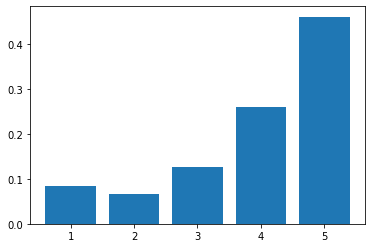

In [73]:
import matplotlib.pyplot as plt
X = [float(r) for r in range(1,6)]
plt.bar(X, [counts[x] for x in X])
plt.show()

#### 1. How should each class augment

In [74]:
augment_prob = {r: max(1.0 / (len(counts)-1) - c,0.) for r,c in counts.items()}
print(augment_prob)
sum_P = sum(augment_prob.values())
print(sum_P)
all_ratings = [float(r) for r in range(1,6)]
augment_multiplier = {r: augment_prob[r] / (sum_P * counts[r]) for r in all_ratings}
print(augment_multiplier)

{1.0: 0.1656719337134458, 2.0: 0.1833854901356472, 3.0: 0.12341702129340967, 4.0: 0.0, 5.0: 0.0}
0.4724744451425027
{1.0: 4.158133953719351, 2.0: 5.826634954567998, 3.0: 2.0635805487782406, 4.0: 0.0, 5.0: 0.0}


#### 2. Augment with variation

In [75]:
import numpy as np
dist_to_prob = [0.2,0.06,0.03,0.01,0.003]
rating_perturbation_prob = {}
for r in all_ratings:
    P = np.array([dist_to_prob[int(abs(r - r_2))] for r_2 in all_ratings])
    P /= np.sum(P)
    rating_perturbation_prob[r] = P
print(rating_perturbation_prob)
augmented_counts = {r: 0 for r in all_ratings}
augmented_records = []
for record in train_review_data:
    record_rating = record['overall']
    M = augment_multiplier[record_rating]
    remainder = M % 1
    M = int(M)+1 if np.random.random() < remainder else int(M)
    sample_amount = np.random.multinomial(M, rating_perturbation_prob[record_rating])
    for i,n_sample in enumerate(sample_amount):
        for j in range(n_sample):
            new_record = {k:v for k,v in record.items()}
            new_record['overall'] = float(i+1)
            augmented_records.append(new_record)
        augmented_counts[float(i+1)] += n_sample
print(augmented_counts)
print(len(augmented_records))

{1.0: array([0.66006601, 0.1980198 , 0.0990099 , 0.0330033 , 0.00990099]), 2.0: array([0.16666667, 0.55555556, 0.16666667, 0.08333333, 0.02777778]), 3.0: array([0.07894737, 0.15789474, 0.52631579, 0.15789474, 0.07894737]), 4.0: array([0.02777778, 0.08333333, 0.16666667, 0.55555556, 0.16666667]), 5.0: array([0.00990099, 0.0330033 , 0.0990099 , 0.1980198 , 0.66006601])}
{1.0: 79972, 2.0: 82496, 3.0: 60328, 4.0: 21286, 5.0: 8887}
252969


In [76]:
data_splits['train'] = data_splits['train'] + augmented_records
print(len(data_splits['train']))

506052


In [77]:
save_pickle(data_splits, './{}/rating_splits_augmented.pkl'.format(short_data_name)) # for rating

#### 3. New counts

In [78]:
train_review_data = data_splits['train']

In [79]:
counts = {float(r): 0 for r in range(1,6)}
for record in train_review_data:
    counts[record['overall']] += 1
T = sum(counts.values())
print(T)
for k,c in counts.items():
    counts[k] = float(counts[k])/T
print(counts)

506052
{1.0: 0.2002047220443749, 2.0: 0.1963335783674405, 3.0: 0.1825187925351545, 4.0: 0.17255143740168993, 5.0: 0.24839146965134018}


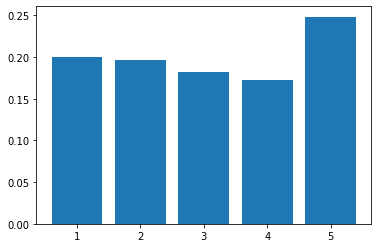

In [80]:
import matplotlib.pyplot as plt
X = [float(r) for r in range(1,6)]
plt.bar(X, [counts[x] for x in X])
plt.show()